# Insurance project

In [1]:
import os
import json
import boto3
import utils 
import joblib
import pickle
import requests
import pandas as pd
import numpy  as np
import boruta as bt
import seaborn as sns
import scikitplot as skplt

from pathlib import Path
from dotenv import load_dotenv
from xgboost import XGBClassifier  
from sklearn import ensemble as en
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from ydata_profiling import ProfileReport
from sqlalchemy import create_engine, text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
print('[Info] Libraries imported successfully')

[Info] Libraries imported successfully


In [2]:
creds, _ = utils.load_credentials()

query = """
   SELECT * FROM insurance
   --limit 100
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 762218 rows and 11 columns imported successfully.


# 1.0. Data Description

In [3]:
df1 = df_raw.copy()

In [4]:
df1.columns

Index(['gender', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [5]:
df1.sample(5)

gender   age  driving_license  region_code  previously_insured  \
201140    Male  23.0              1.0         23.0                 1.0   
526065  Female  43.0              1.0         47.0                 0.0   
738061  Female  28.0              1.0         35.0                 0.0   
748788    Male  42.0              1.0          8.0                 0.0   
730300    Male  25.0              1.0          8.0                 0.0   

       vehicle_age vehicle_damage  annual_premium  policy_sales_channel  \
201140    < 1 Year             No         23614.0                 151.0   
526065    1-2 Year            Yes         27368.0                  26.0   
738061    < 1 Year            Yes         37086.0                 152.0   
748788    1-2 Year            Yes         33028.0                  26.0   
730300    1-2 Year            Yes          2630.0                 156.0   

        vintage  response  
201140     75.0       0.0  
526065    245.0       0.0  
738061     56.0       0.0  
748788     64.0       0.0  
730300    250.0       0.0

## 1.1. Data Dimension

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 762218
Number of Columns: 11


## 1.2. Data Types

In [7]:
df1.dtypes

gender                   object
age                     float64
driving_license         float64
region_code             float64
previously_insured      float64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                float64
dtype: object

In [8]:
df1['age'] = df1['age'].astype(int)
df1['driving_license'] = df1['driving_license'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)
df1['previously_insured'] = df1['previously_insured'].astype(int)
df1['vintage'] = df1['vintage'].astype(int)
df1['response'] = df1['response'].astype(int)

In [9]:
df1.dtypes

gender                   object
age                       int32
driving_license           int32
region_code               int32
previously_insured        int32
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int32
response                  int32
dtype: object

## 1.3. Check NA

In [10]:
df1.isna().sum()

gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [11]:
profile = ProfileReport(df1, title="Profiling Report")

In [12]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profile.to_file("EDA_aux.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
%matplotlib inline

In [15]:
utils.statistical_summary(dataframe = df1)

attributes     min       max     range          mean   median  \
0                   age    20.0      85.0      65.0     38.822584     36.0   
1       driving_license     0.0       1.0       1.0      0.997869      1.0   
2           region_code     0.0      52.0      52.0     26.388807     28.0   
3    previously_insured     0.0       1.0       1.0      0.458210      0.0   
4        annual_premium  2630.0  540165.0  537535.0  30564.389581  31669.0   
5  policy_sales_channel     1.0     163.0     162.0    112.034295    133.0   
6               vintage    10.0     299.0     289.0    154.347397    154.0   
7              response     0.0       1.0       1.0      0.122563      0.0   

            std       skew    kurtosis  
0     15.511591   0.672538   -0.565659  
1      0.046109 -21.595139  464.351248  
2     13.229871  -0.115266   -0.867859  
3      0.498251   0.167747   -1.971866  
4  17213.132474   1.766084   34.004338  
5     54.203924  -0.900006   -0.970812  
6     83.671194   0.003030   -1.200688  
7      0.327935   2.301901    3.298758

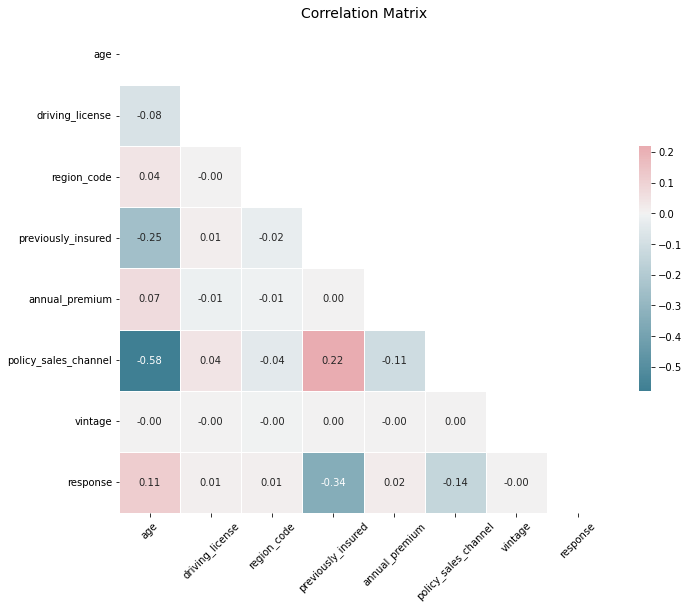

In [16]:
utils.correlation_matrix(dataframe = df1)

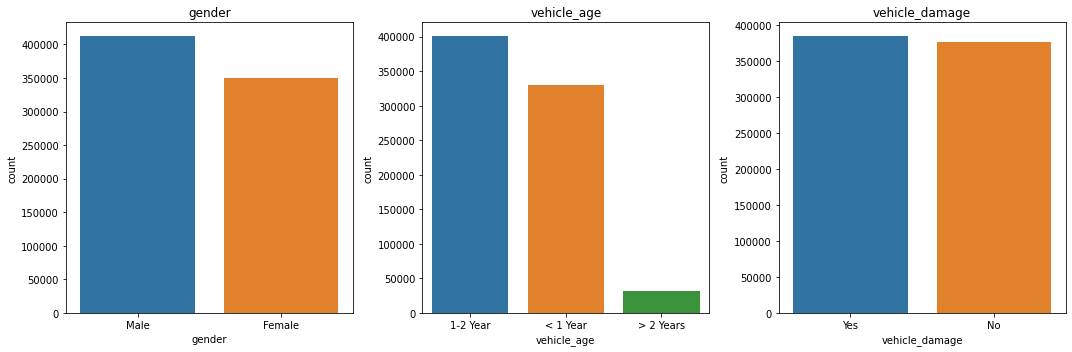

In [17]:
utils.plot_categorical_features(dataframe = df1)

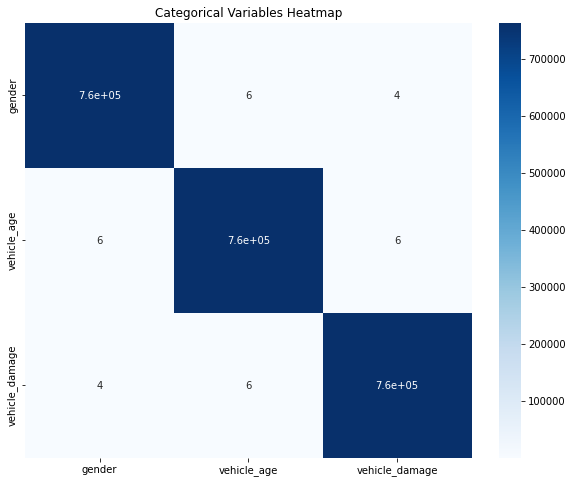

In [18]:
utils.plot_categorical_heatmap(dataframe = df1)

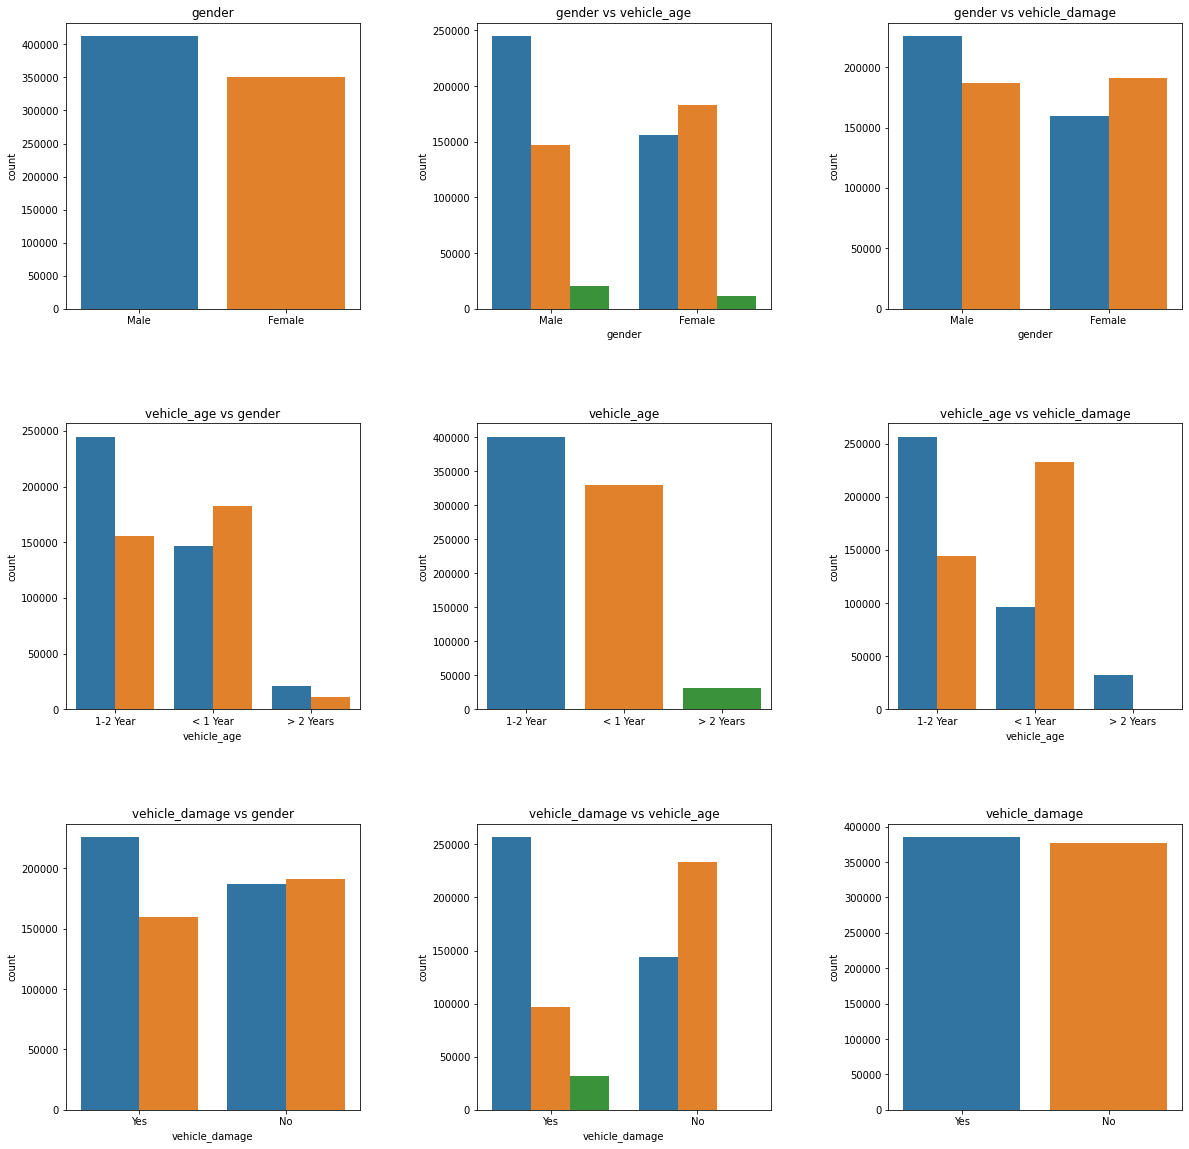

In [19]:
utils.plot_clustered_bars(dataframe = df1)

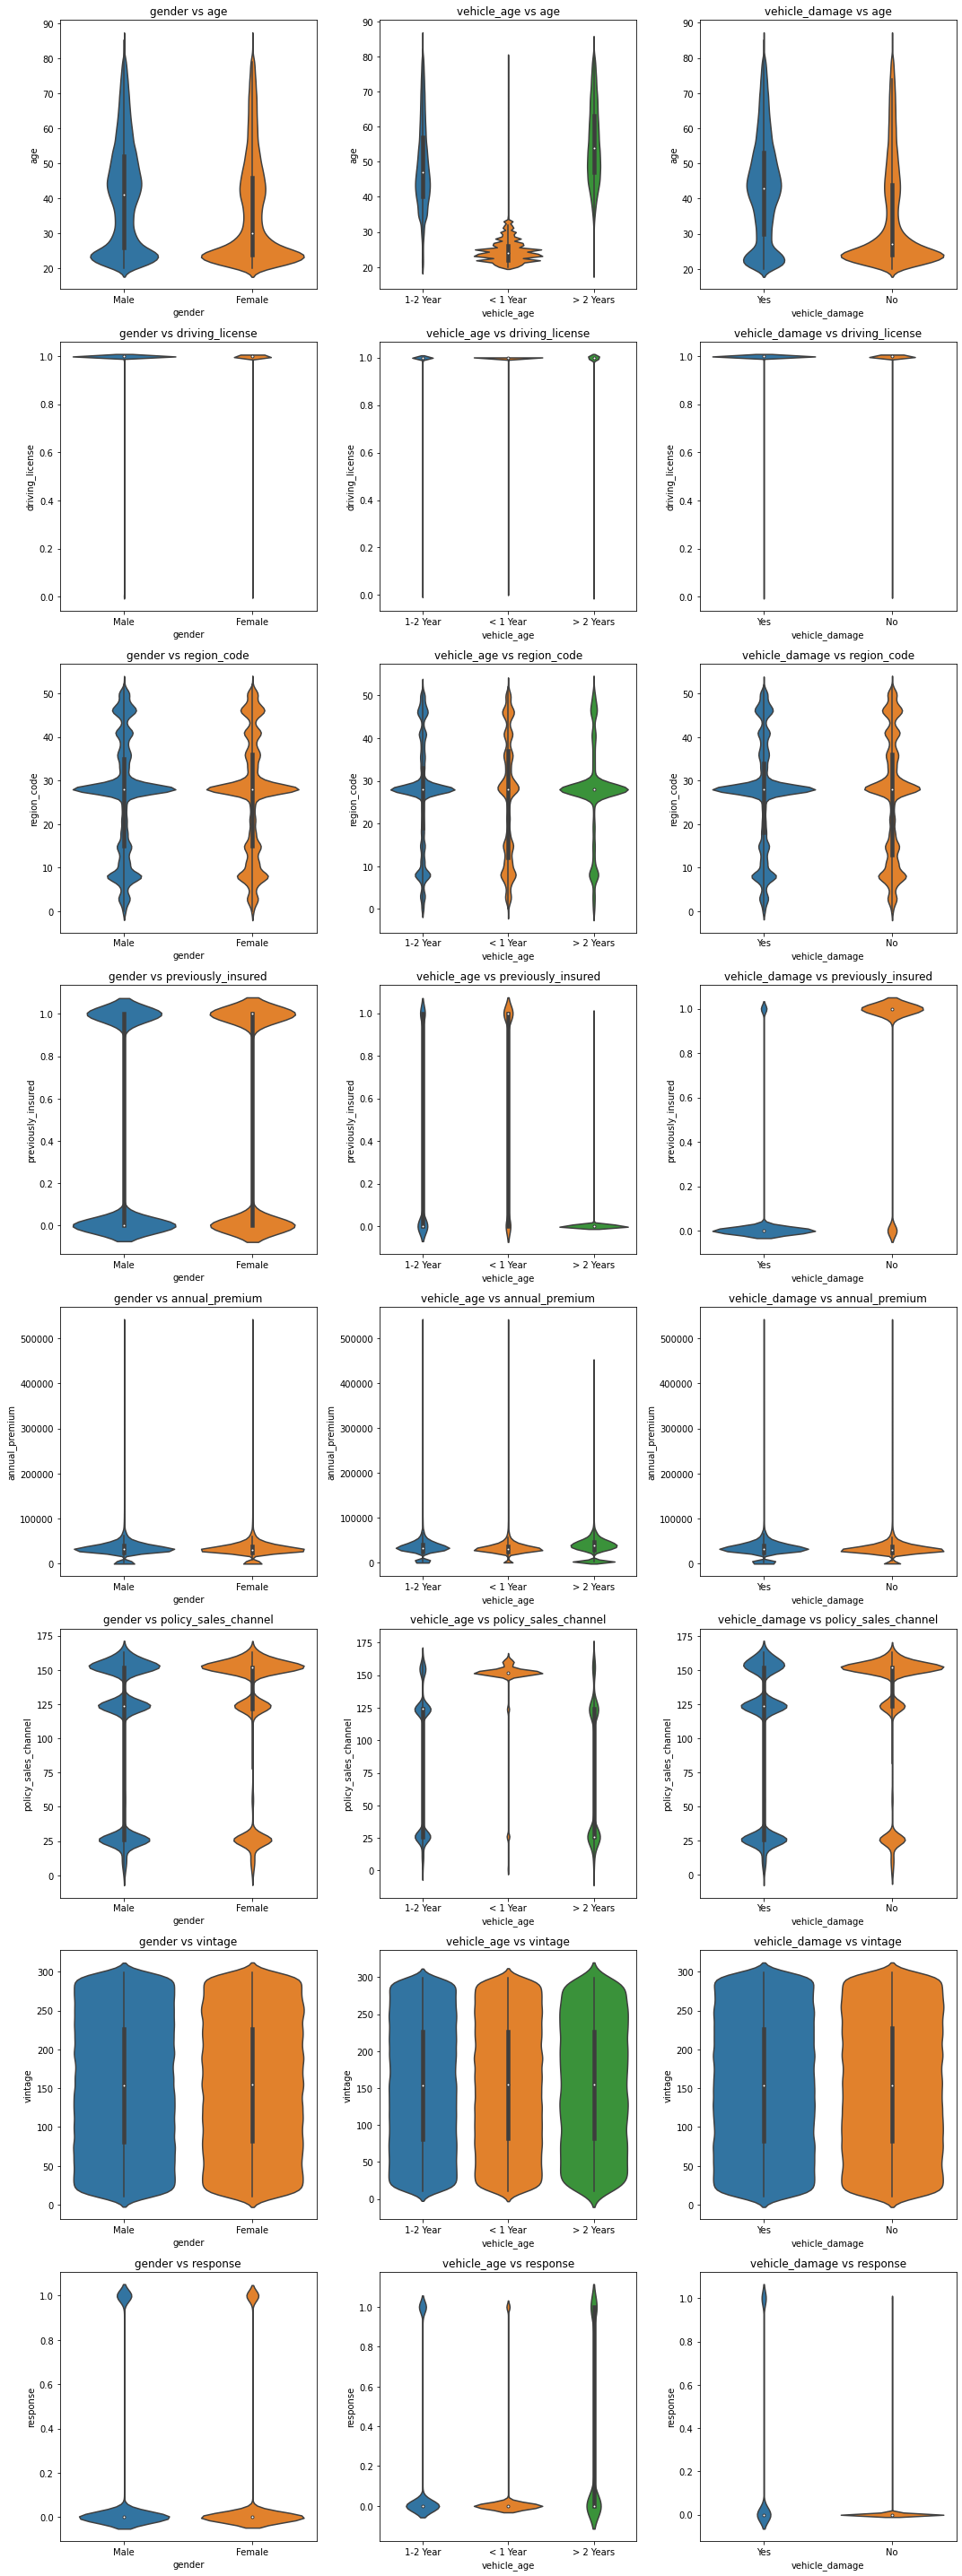

In [20]:
utils.plot_categorical_numerical_interactions(dataframe = df1)

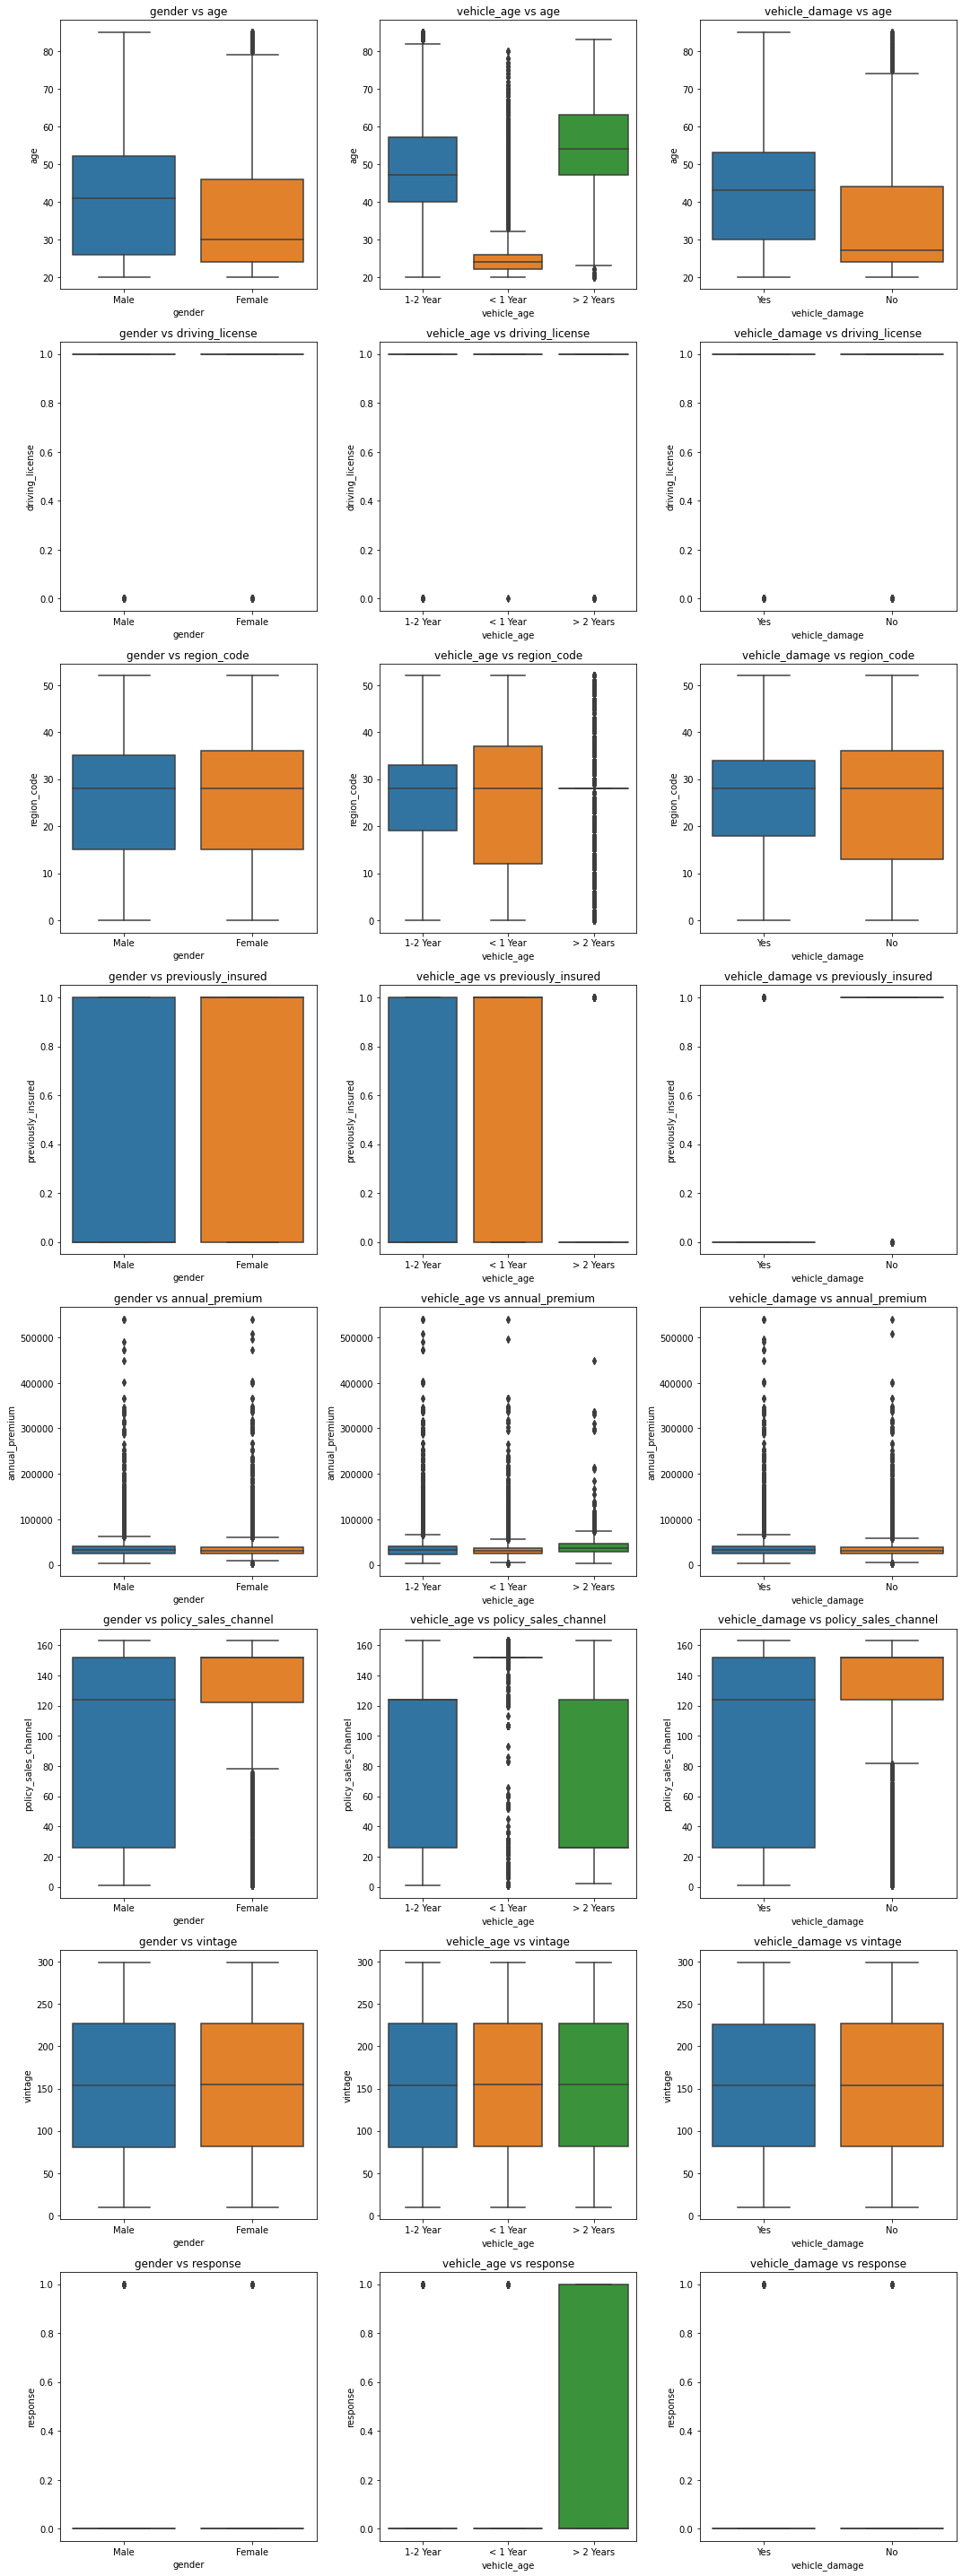

In [21]:
utils.plot_categorical_numerical_interactions(dataframe = df1, 
                                              plot_type = 'boxplot')

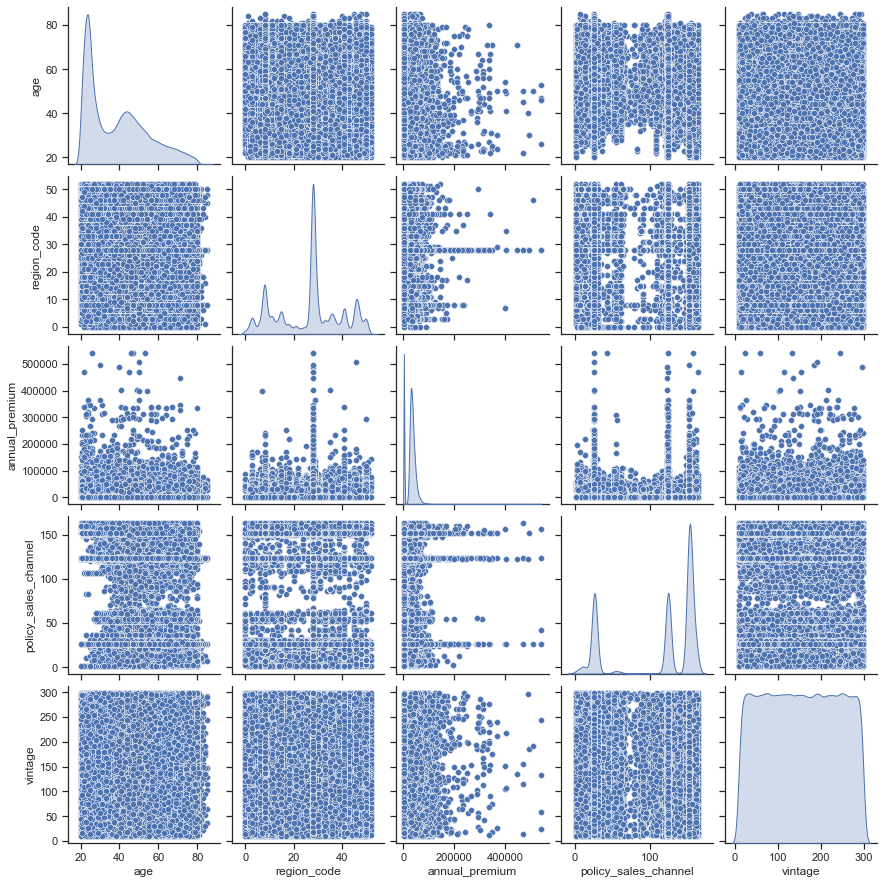

In [22]:
utils.scatterplot_matrix_numeric(dataframe = df1)

# 2.0. Feature Engineering

In [23]:
df2 =  df1.copy()

In [24]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [25]:
df2.sample(5)

gender  age  driving_license  region_code  previously_insured  \
464997  Female   48                1           11                   0   
739457    Male   25                1            6                   1   
737746  Female   51                1           28                   0   
70074     Male   67                1            6                   0   
644833    Male   44                1           28                   0   

             vehicle_age  vehicle_damage  annual_premium  \
464997  between_1_2_year               1         35906.0   
739457      below_1_year               0         16320.0   
737746  between_1_2_year               1         41537.0   
70074   between_1_2_year               1         43556.0   
644833  between_1_2_year               1         57673.0   

        policy_sales_channel  vintage  response  
464997                 124.0      280         0  
739457                 152.0      269         0  
737746                 124.0       24         0  
70074                  122.0      237         0  
644833                 124.0      117         1

# 3.0. Data Filtering

In [26]:
df4 = df2.copy()

# 5.0. Data Preparation

In [27]:
X = df4.drop( 'response', axis=1 )
y = df4['response']

x_train, x_validation, y_train, y_validation = model_selection.train_test_split( X, y, 
                                                                                test_size=0.20,
                                                                                random_state = 42)

df5 = pd.concat( [x_train, y_train], axis=1 )

In [28]:
param_root = Path('parameters')
if param_root.exists(): 
    print(f'[Info] {param_root} already exists')
else: 
    param_root.mkdir(parents=True, exist_ok = True)
    print(f'[Info] {param_root} was created successfully')

[Info] parameters already exists


## Standardization

In [29]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
trans_path = param_root/'annual_premium_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(ss, file)

## Rescaling

In [30]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
trans_path = param_root/'age_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(mms_age, file)

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
trans_path = param_root/'vintage_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(mms_vintage, file)

## Encoder

In [31]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
trans_path = param_root/'gender_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(target_encode_gender, file)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
trans_path = param_root/'region_code_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(target_encode_region_code, file)

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
trans_path = param_root/'policy_sales_channel_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(fe_policy_sales_channel, file)

In [32]:
# !zip parameters.zip -r parameters
# !zip models.zip -r models

## 5.4. Validation Preparation

In [33]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

In [34]:
x_train_n = df5.drop( 'response', axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


In [35]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( 'response', axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [36]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( 'response', axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

[Info] Feature ranking:
                        feature  importance
0                       vintage    0.274165
0                annual_premium    0.246286
0                           age    0.163804
0                   region_code    0.105014
0                vehicle_damage    0.069413
0          policy_sales_channel    0.058769
0            previously_insured    0.055063
0      vehicle_age_below_1_year    0.013531
0  vehicle_age_between_1_2_year    0.006318
0                        gender    0.004793
0      vehicle_age_over_2_years    0.002357
0               driving_license    0.000487


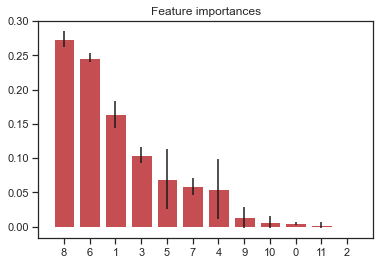

In [37]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("[Info] Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [38]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [39]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

In [40]:
finetuned_parameters = {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 0.01, 'reg_lambda': 0.01}


models = {
    "KNN": KNeighborsClassifier(n_neighbors=7 ),
    "Logistic Regression": LogisticRegression(random_state=42),
#     "Extra Trees": ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
#     "Random Forest": RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ),
    "XGBoost": XGBClassifier(), #baseline
    "XGBoost finetuned": XGBClassifier(seed=0, #bayesian finetunning (apparently best model)
                           colsample_bytree = finetuned_parameters['colsample_bytree'], #space_eval(space, best)['colsample_bytree'], 
                           gamma = finetuned_parameters['gamma'],        #space_eval(space, best)['gamma'], 
                           learning_rate = finetuned_parameters['learning_rate'],        #space_eval(space, best)['learning_rate'], 
                           max_depth = finetuned_parameters['max_depth'],        #space_eval(space, best)['max_depth'], 
                           reg_alpha = finetuned_parameters['reg_alpha'],        #space_eval(space, best)['reg_alpha'],
                           reg_lambda = finetuned_parameters['reg_lambda']        #space_eval(space, best)['reg_lambda']
                           )
}


[Info] Path models\figures already exists.
[Info] Path models\models already exists.
[Info] Path models\models created.


C:\Users\Windows\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] KNN results exported successfully


C:\Users\Windows\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] Logistic Regression results exported successfully


C:\Users\Windows\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] XGBoost results exported successfully


C:\Users\Windows\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] XGBoost finetuned results exported successfully


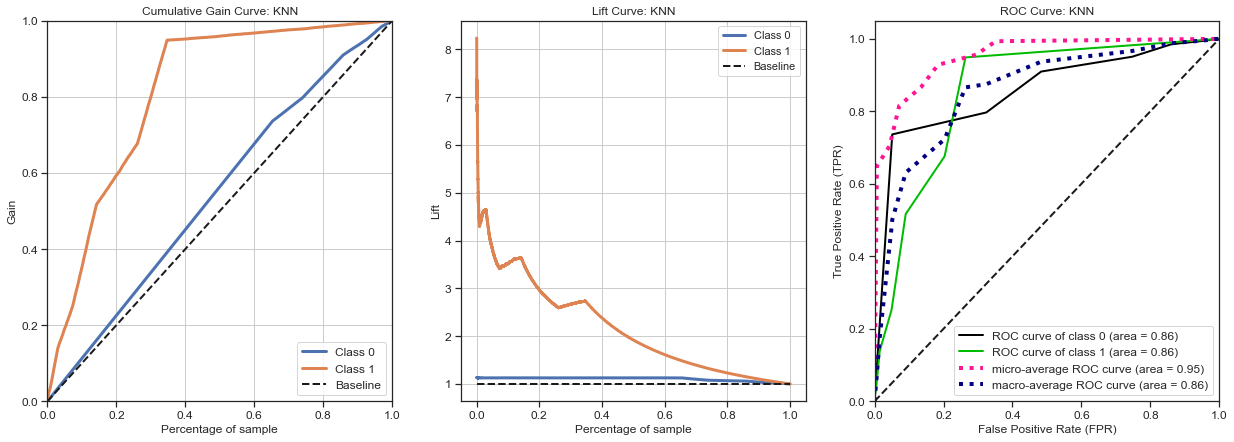

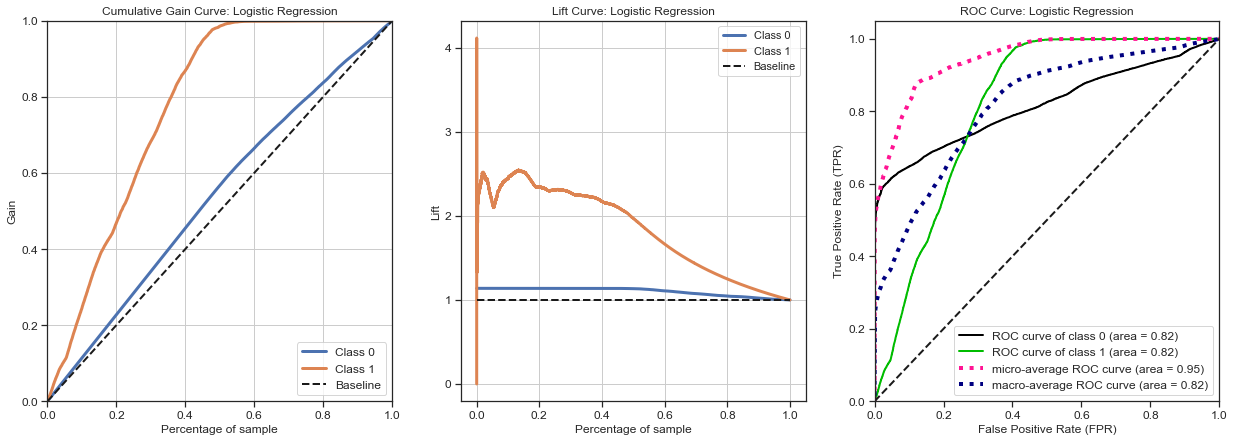

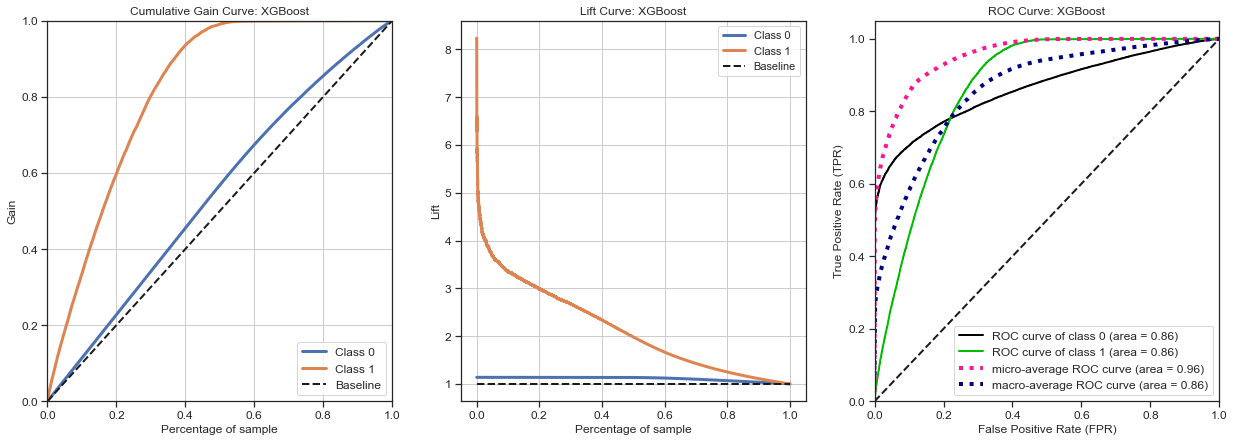

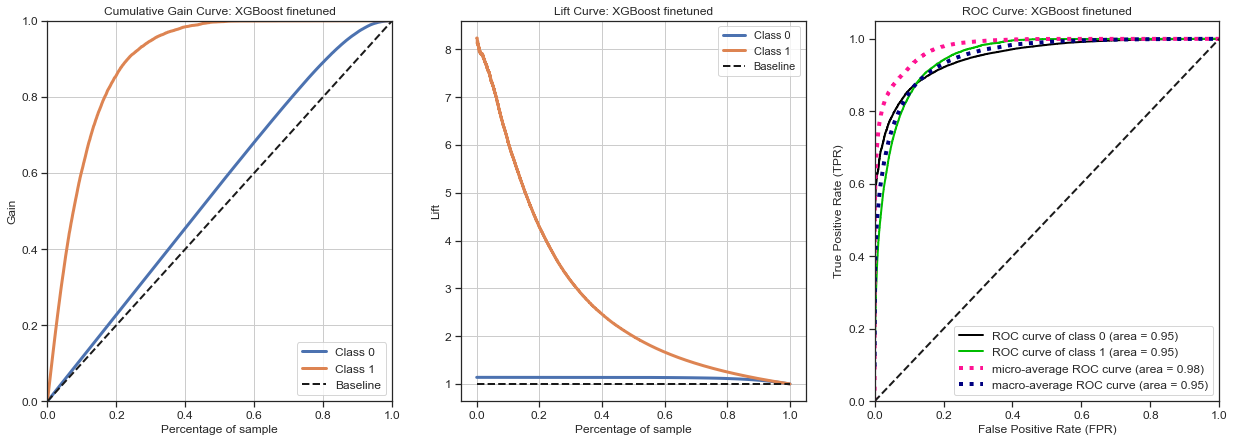

In [41]:
utils.model_assessment(models = models,
                       x_train = x_train, 
                       y_train = y_train,
                       x_test = x_val,
                       y_test = y_val)

### Fine parameter tuning

In [42]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


# Objective function
def objective(params):
  xgboost = XGBClassifier(seed=0, **params)
  score = cross_val_score(estimator=xgboost, 
                            X=x_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='average_precision', 
                            n_jobs=-1).mean()
  # Loss is negative score
  loss = - score
  # Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

# Print the values of the best parameters
print(space_eval(space, best))

100%|██████████| 48/48 [2:01:50<00:00, 152.29s/trial, best loss: -0.6494671814243413]  
{'colsample_bytree': 0.6, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}


# Testing the class 

In [43]:
creds, _ = utils.load_credentials()
query = """
   SELECT * FROM insurance
   
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 762218 rows and 11 columns imported successfully.


In [44]:
from InsuranceClass.HealthInsuranceClass import HealthInsurance
test = HealthInsurance()

In [45]:
_ ,creds = utils.load_credentials()

utils.upload_class_data_AWS_S3(df = df_raw,  
                               model_name = 'xgboost_finetuned',
                               aws_update = True, 
                               aws_access_key_id = creds['aws_access_key_id'], 
                               aws_secret_access_key = creds['aws_secret_access_key'],
                               testing_class = test,
                               bucket = 'insurance-data')

Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/13/data_raw.csv
[Info] raw data created
Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/13/data_cleaning.csv
[Info] data_cleaning method applied
Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/13/feature_engineering.csv
[Info] feature_enginerring method applied
Uploaded 762218 rows and 7 columns to s3://insurance-data/data_versions/2023/5/13/data_preparation.csv
[Info] data_preparation method applied
Uploaded 762218 rows and 11 columns to s3://insurance-data/data_versions/2023/5/13/prediction_xgboost_finetuned.csv
[Info] prediction method applied


gender   age  driving_license  region_code  previously_insured  \
0         Male  54.0              1.0          8.0                 0.0   
1         Male  31.0              1.0         36.0                 0.0   
2         Male  20.0              1.0         46.0                 1.0   
3         Male  45.0              1.0         30.0                 0.0   
4         Male  26.0              1.0         28.0                 1.0   
...        ...   ...              ...          ...                 ...   
762213    Male  48.0              1.0         45.0                 0.0   
762214    Male  25.0              1.0         46.0                 0.0   
762215  Female  49.0              1.0         47.0                 1.0   
762216  Female  56.0              1.0         15.0                 1.0   
762217  Female  41.0              1.0         28.0                 0.0   

       vehicle_age vehicle_damage  annual_premium  policy_sales_channel  \
0         1-2 Year            Yes         45375.0                 124.0   
1         < 1 Year            Yes         25264.0                 151.0   
2         < 1 Year             No         33570.0                 152.0   
3         1-2 Year            Yes         39937.0                  26.0   
4         < 1 Year             No         40651.0                 154.0   
...            ...            ...             ...                   ...   
762213    1-2 Year            Yes         44800.0                 124.0   
762214    < 1 Year             No         45604.0                 152.0   
762215    1-2 Year             No         26056.0                 152.0   
762216    1-2 Year             No          2630.0                  14.0   
762217    1-2 Year            Yes         24772.0                 124.0   

        vintage     score  
0          54.0  0.830954  
1         221.0  0.864701  
2         270.0  0.999410  
3          95.0  0.717718  
4         293.0  0.999698  
...         ...       ...  
762213    289.0  0.890522  
762214     15.0  0.997095  
762215    214.0  0.999925  
762216    297.0  0.999496  
762217    281.0  0.654304  

[762218 rows x 11 columns]

# Testing API locally and deployed

In [46]:
creds, _ = utils.load_credentials()
query = """
   SELECT * FROM insurance
   limit 100
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 100 rows and 11 columns imported successfully.


In [47]:
data = json.dumps(df_raw.drop('response', axis = 1).to_dict( orient='records' ))


# url = 'https:0.0.0.0:8000/predict'
url = 'https://health-insurance-api-oanp.onrender.com/predict'

# API Call
header = {'Content-type': 'application/json' }
r = requests.post( url, data=data, headers=header )
print( f'[Info] Status Code {r.status_code}' )

pd.DataFrame(json.loads(r.json()))

[Info] Status Code 200


gender  age  driving_license  region_code  previously_insured vehicle_age  \
0     Male   54                1            8                   0    1-2 Year   
1     Male   31                1           36                   0    < 1 Year   
2     Male   20                1           46                   1    < 1 Year   
3     Male   45                1           30                   0    1-2 Year   
4     Male   26                1           28                   1    < 1 Year   
..     ...  ...              ...          ...                 ...         ...   
95  Female   45                1           37                   0    1-2 Year   
96  Female   54                1           28                   0    1-2 Year   
97  Female   29                1            2                   1    < 1 Year   
98  Female   24                1           30                   1    < 1 Year   
99  Female   35                1           46                   1    1-2 Year   

   vehicle_damage  annual_premium  policy_sales_channel  vintage     score  
0             Yes           45375                   124       54  0.890550  
1             Yes           25264                   151      221  0.895661  
2              No           33570                   152      270  0.999656  
3             Yes           39937                    26       95  0.722023  
4              No           40651                   154      293  0.999335  
..            ...             ...                   ...      ...       ...  
95             No           28156                   124      296  0.992822  
96            Yes           46265                    26      234  0.762090  
97             No           35534                   152       55  0.999698  
98             No            2630                   152       80  0.999761  
99             No            2630                   152      202  0.999723  

[100 rows x 11 columns]

In [ ]:
Yeeeiiii :) 